# Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vale\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vale\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_json('arxiv-metadata-oai-snapshot.json', lines=True)
print(data.head())

          id           submitter  \
0  0704.0001      Pavel Nadolsky   
1  0704.0002        Louis Theran   
2  0704.0003         Hongjun Pan   
3  0704.0004        David Callan   
4  0704.0005  Alberto Torchinsky   

                                             authors  \
0  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...   
1                    Ileana Streinu and Louis Theran   
2                                        Hongjun Pan   
3                                       David Callan   
4           Wael Abu-Shammala and Alberto Torchinsky   

                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2  The evolution of the Earth-Moon system based o...   
3  A determinant of Stirling cycle numbers counts...   
4  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                  comments  \
0  37 pages, 15 figures; published version   
1    To appear in

In [23]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def mapping(x):
        """ Map POS tags into characters recognized by the lemmatizer """
        if x[1] == 'ADV': 
            pos = 'r'
        elif x[1] == 'ADJ':
            pos = 'a'
        elif x[1] == 'VERB':
            pos = 'v'
        else:
            pos = 'n'
        return (x[0], pos)
    
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text) # no 1-2 letter words (eg "a", "an", "is")
    text = re.sub(r'[^\w\s]', '', text) # no not alphanumeric characters
    text = re.sub(r'\d+', ' ', text) # no digits

    words = [word for word in text.split() if word not in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(lemmatized_words)

In [25]:
def contains_top_author(authors):
    author_list = [author.strip() for author in authors.split(',')]
    return any(author in top_authors for author in author_list)

# Task 1

## Task 1.1: Most Commonly Used Category in Papers
What is the most commonly used category in papers in ArXiv? Prepare a visualization of the distribution of categories (e.g. prepare a barplot presenting the number of occurrences of each category).

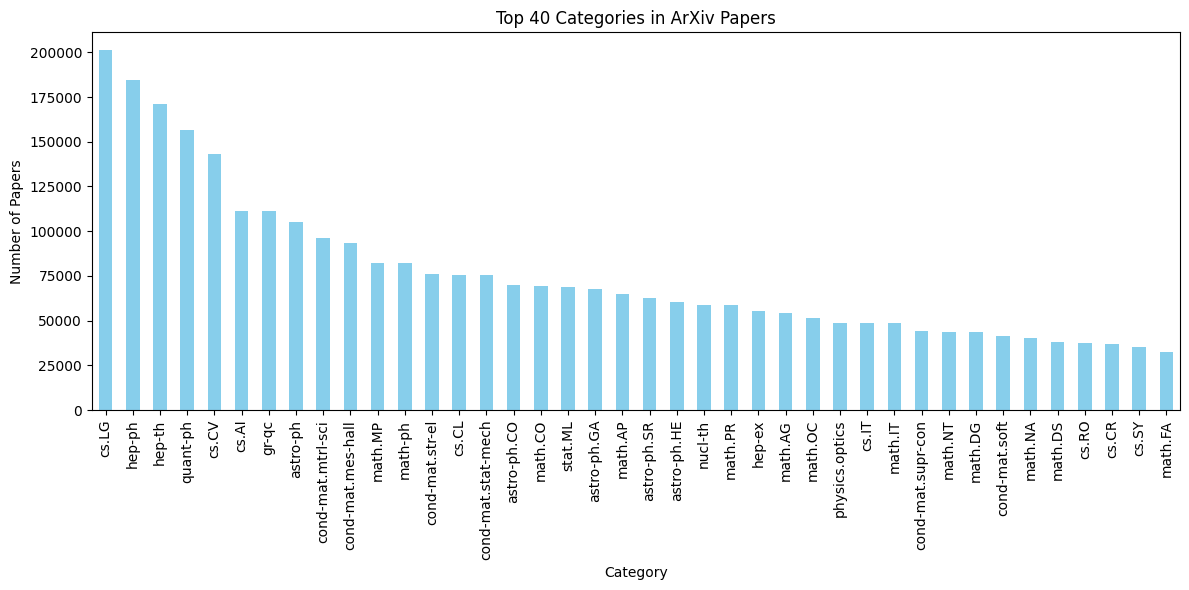

In [14]:
categories_series = data['categories'].str.split(expand=True).stack()
category_counts = categories_series.value_counts()

top_n = 40
top_categories = category_counts.head(top_n)

plt.figure(figsize=(12, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Categories in ArXiv Papers')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.tight_layout()
plt.show()

## Task 1.2: Word Cloud for a Chosen Category
For one category of your choice, prepare a word cloud based on the available abstracts.

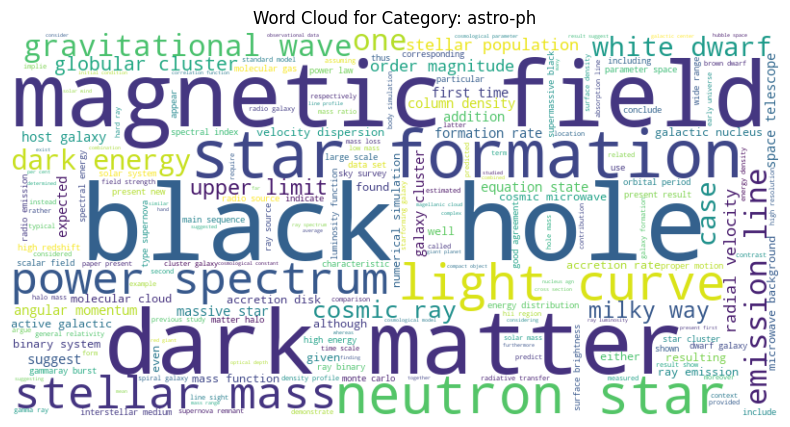

In [17]:
chosen_category = 'astro-ph'
filtered_abstracts = data[data['categories'].str.contains(chosen_category, na=False)]['abstract']

processed_text = ' '.join(filtered_abstracts)
processed_text = preprocess_text(processed_text)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for Category: {chosen_category}')
plt.show()

## Task 1.3: Top Words for Most Common Categories
For the 5 top most commonly used categories, find the top 3 words used in abstracts.

In [18]:
top_5_categories = category_counts.head(5).index

top_words_by_category = {}

for category in top_5_categories:
    abstracts = data[data['categories'].str.contains(category, na=False)]['abstract']
    
    processed_text = preprocess_text(' '.join(abstracts))
    
    vectorizer = CountVectorizer(max_features=3)
    word_matrix = vectorizer.fit_transform([processed_text])
    top_words = vectorizer.get_feature_names_out()
    top_word_counts = word_matrix.toarray()[0]
    
    top_words_by_category[category] = list(zip(top_words, top_word_counts))

for category, words in top_words_by_category.items():
    print(f"Category: {category}")
    for word, count in words:
        print(f"  {word}: {count}")

Category: cs.LG
  data: 215948
  learning: 236722
  model: 343135
Category: hep-ph
  mass: 117464
  model: 166170
  neutrino: 72296
Category: hep-th
  field: 137164
  model: 116192
  theory: 178260
Category: quant-ph
  quantum: 344337
  state: 174724
  system: 121491
Category: cs.CV
  image: 231421
  method: 191253
  model: 218847


# Task 2

Based on available data create a graph that shows some kind of relationship between authors.

Due to the challenge of generating easy readable graphs and the computational difficulties associated with very densely populated graphs, I focused on the top 1000 authors (by paper count) and in the dataset and explored their co-authorship relationships.

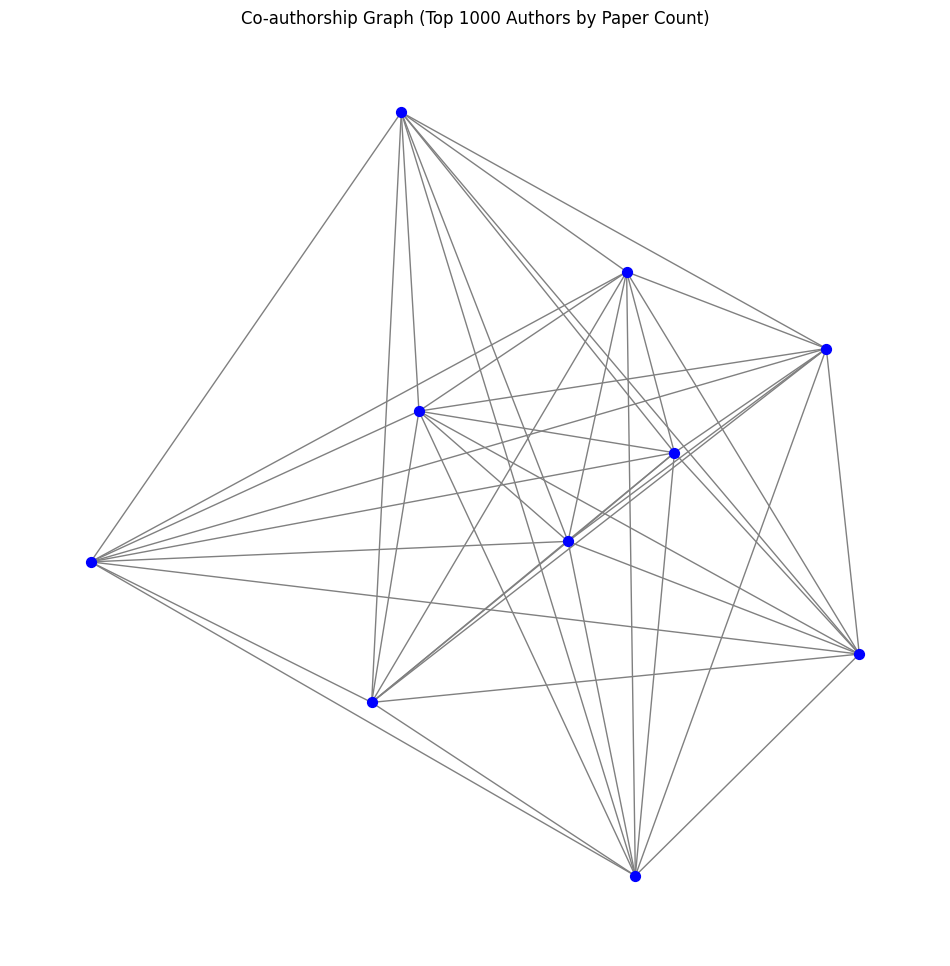

In [30]:
author_paper_counts = data['authors'].str.split(',').explode().value_counts()

top_n = 1000
top_authors = author_paper_counts.head(top_n).index
data_filtered = data[data['authors'].dropna().apply(contains_top_author)]

author_pairs = []
for authors in data_filtered['authors']:
    author_list = [author.strip() for author in authors.split(',') if author.strip() in top_authors]
    for i in range(len(author_list)):
        for j in range(i + 1, len(author_list)):
            if author_list[i] != author_list[j]:  # to avoid self-loops
                author_pairs.append((author_list[i], author_list[j]))

G = nx.Graph()
for pair in author_pairs:
    if G.has_edge(pair[0], pair[1]):
        G[pair[0]][pair[1]]['weight'] += 1
    else:
        G.add_edge(pair[0], pair[1], weight=1)

min_weight = 2
edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if w['weight'] < min_weight]
G.remove_edges_from(edges_to_remove)

nodes_to_remove = [node for node in G.nodes if G.degree(node) == 0]
G.remove_nodes_from(nodes_to_remove)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(G, pos, edge_color='gray')
plt.title(f'Co-authorship Graph (Top {top_n} Authors by Paper Count)')
plt.axis('off')
plt.show()